<a href="https://colab.research.google.com/github/amantericsoft/frisking-project/blob/main/Frisking3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import glob

In [ ]:
!pip install mediapipe

     |████████████████████████████████| 30.1 MB 13 kB/s 


In [ ]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

In [ ]:
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[5,5])
        #plt.subplot(111);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(111);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        #mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        return output_image, landmarks
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

In [ ]:
def getHandCoordinate(black_image):
    hand_coordinate = []
    for i in range(black_image.shape[0]):
        for j in range(black_image.shape[1]):

            if black_image[i][j] == 255:
                hand_coordinate.append([i, j, 0])

    return hand_coordinate            


In [ ]:
def checkPixelPresent(hand_coordinate, labels_path):

      labels_path_list = glob.glob(labels_path)
      copy_hand_coordinate = hand_coordinate
      for label_path in labels_path_list:
          label_file = open(label_path,"r")
          label = label_file.readline()[:-1].split(",")  # label is like ['Detector', '627', '545', '210', '175']
          x1 = int(label[1]); y1 = int(label[2])
          x2 = int(label[1])+int(label[3]); y2 = int(label[2])
          x3 = int(label[1]); y3 = int(label[2])+int(label[4])
          x4 = int(label[1])+int(label[3]); y4 = int(label[2])+int(label[4])

          idx = 0  
          
          while(len(hand_coordinate) > 0 and idx < len(hand_coordinate)):
              
              coordinate =  hand_coordinate[idx] 
              if coordinate[0] > x1 and coordinate[0] < x2 and coordinate[1] > y1 and coordinate[1] < y3:
                  
                  hand_coordinate[idx][2] = 1     

              idx += 1    

      return hand_coordinate

In [ ]:
def ColoringVisitedAndUnvisited(image, hand_coordinate):
    count_green = 0
    count_red = 0
    for coordinate in hand_coordinate:
        
        if coordinate[2] == 1:
            image[coordinate[0]][coordinate[1]] = [0, 255, 0]
            count_green += 1
        if coordinate[2] == 0:
            image[coordinate[0]][coordinate[1]] = [0, 0, 255] 
            count_red += 1   
    accuracy = count_green / (count_green+count_red)  

    return image, accuracy       

In [ ]:
# define a video capture object
video_path = "/content/Frisking/moving left hand.mp4"
labels_path = "/content/Frisking/Labels/*"

In [ ]:
labels_path_list = glob.glob(labels_path)
labels_path_list = sorted(labels_path_list)

In [ ]:
labels_path_list[0]

'/content/Frisking/Labels/00000026.txt'

In [ ]:
labels_path_list[0][-12:-4]

'00000026'

In [ ]:
def getSkeleton(black_image, landmarks, mp_pose):

    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    left_elbow = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
    left_wrist = landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]


    skeleton_image = cv2.circle(black_image, (left_shoulder[0], left_shoulder[1]), 10, (255,0,0), -1)
    skeleton_image = cv2.circle(skeleton_image, (left_elbow[0], left_elbow[1]), 10, (255,0,0), -1)
    skeleton_image = cv2.circle(skeleton_image, (left_wrist[0], left_wrist[1]), 10, (255,0,0), -1)

    skeleton_image = cv2.line(skeleton_image, (left_shoulder[0], left_shoulder[1]), (left_elbow[0], left_elbow[1]), (255,0,0), 8)
    skeleton_image = cv2.line(skeleton_image, (left_elbow[0], left_elbow[1]), (left_wrist[0], left_wrist[1]), (255,0,0), 8)


    return skeleton_image

In [ ]:
def getDetectorPosition(black_image, detector_frame_path):
  
    label_file = open(detector_frame_path,"r")
    label = label_file.readline()[:-1].split(",")  # label is like ['Detector', '627', '545', '210', '175']
    x1 = int(label[1]); y1 = int(label[2])
    x2 = int(label[1])+int(label[3]); y2 = int(label[2])
    x3 = int(label[1]); y3 = int(label[2])+int(label[4])
    x4 = int(label[1])+int(label[3]); y4 = int(label[2])+int(label[4])

    detector_image = cv2.rectangle(black_image, (x1, y1), (x4, y4), (255, 0, 0), -1)

    return detector_image      


In [ ]:
def getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates):

    x1_detector =  detector_coordinates[0]
    y1_detector = detector_coordinates[1]
    detector_width = detector_coordinates[2]
    detector_height = detector_coordinates[3]


    x_diff = keypoint2[0] - keypoint1[0]
    y_diff = keypoint2[1] - keypoint1[1]

    if abs(x_diff) > abs(y_diff):
        max_diff = abs(x_diff)
    else:
        max_diff = abs(y_diff)  

    x_change = x_diff/max_diff
    y_change = y_diff/max_diff    

    x1 = keypoint1[0]; y1 = keypoint1[1]
    x2 = keypoint2[0]; y2 = keypoint2[1]
    overlap_coordinates = []

    #print(f"x chnage : {x_change} and x change : {y_change}")
    #print(f"detector_x : {x1_detector} and detector_x_width : {x1_detector+detector_width}")
    #print(f"detector_y : {y1_detector} and detector_y_width : {y1_detector+detector_height}")

    start_found = "false"

    for i in range(max_diff+1):  

            #print(f"(x1, y1) : ({int(x1)}, {int(y1)})")

            if (int(x1) > x1_detector or int(x1) == x1_detector) and  (int(x1) < (x1_detector+detector_width) or int(x1) == (x1_detector+detector_width)):
                if (int(y1) > y1_detector or int(y1) == y1_detector) and  (int(y1) < (y1_detector+detector_height) or int(y1) == (y1_detector+detector_height)):

                    if start_found == "false":
                        overlap_start = i
                        start_found = "true"

                    overlap_end = i    
                    overlap_coordinates.append([x1, y1])

            x1 += x_change
            y1 += y_change

    #p1 = [overlap_coordinates[0][0], overlap_coordinates[0][1]]
    #p2 = [overlap_coordinates[-1][0], overlap_coordinates[-1][1]]

    #print(f"Overlap coordinates : {overlap_coordinates}")
    #print(f"keypoint1 : {keypoint1}")
    #print(f"keypoint2 : {keypoint2}")
    #print(f"p1 : {p1}")
    #print(f"p2 : {p2}")

    overlap_start /= max_diff
    overlap_end /= max_diff

    
    #distance_between_keypoints = math.sqrt( ((keypoint2[0]-keypoint1[0])**2)+((keypoint2[1]-keypoint1[1])**2) )
    #overlap_start =  math.sqrt( ((p1[0]-keypoint1[0])**2)+((p1[1]-keypoint1[1])**2) ) /  distance_between_keypoints   
    #overlap_end =  math.sqrt( ((p2[0]-keypoint1[0])**2)+((p2[1]-keypoint1[1])**2) )  / distance_between_keypoints 

    #print(f"overlap start : {overlap_start}")
    #print(f"overlap end : {overlap_end}")


    return overlap_coordinates, overlap_start, overlap_end

In [ ]:
def detectPose(image, black_image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []

    output_image = black_image
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.print(f"1. overlap start : {overlap_start} and overlap end : {overlap_end}")(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[10,10])
        #plt.subplot(111);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(111);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        #mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        return output_image, landmarks
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

In [ ]:
def getColoringOfSkeleton(black_image, keypoint1, keypoint2):
    
    x_diff = keypoint2[0] - keypoint1[0]
    y_diff = keypoint2[1] - keypoint1[1]

    if abs(x_diff) > abs(y_diff):
        max_diff = abs(x_diff)
    else:
        max_diff = abs(y_diff)  

    x_change = x_diff/max_diff
    y_change = y_diff/max_diff    

    #print("(x diff, y1 diff)", x_diff, y_diff)
    #print("x change", x_change)
    #print("y change", y_change)
    #print("max diff", max_diff)


    x1 = keypoint1[0]; y1 = keypoint1[1]
    x2 = keypoint2[0]; y2 = keypoint2[1]
    #x2 = keypoint2[0] + abs(x_change)/x_change; y2 = keypoint2[1] + abs(y_change)/y_change


    #print("(x1, y1)", x1, y1)
    #print("(x2, y2)", x2, y2)
    #print(x_change)
    #print(y_change)
    #print("max diff", max_diff)

    #while( int(x1) != x2 and int(y1) != y2 ):
    for i in range(max_diff):  
            
            black_image[int(y1)][int(x1)] = [0, 0, 255]            
            x1 += x_change    
            y1 += y_change


    return black_image        

In [ ]:
def getFullBodySkeleton(black_image, mp_pose, landmarks):

    left_shoulder_point = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    right_shoulder_point = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    left_hip_point = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
    right_hip_point = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
    left_elbow_point = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
    left_wrist_point = landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]

    left_shoulder_point = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    right_shoulder_point = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    left_elbow_point = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
    right_elbow_point = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value]
    left_wrist_point = landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]
    right_wrist_point = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value]
    left_hip_point = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
    right_hip_point = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
    left_knee_point = landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value]
    right_knee_point = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value]
    left_ankle_point = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value]
    right_ankle_point = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value]


    black_image = cv2.circle(black_image, (left_shoulder_point[0], left_shoulder_point[1]), 3, (0,0,255), -1)
    black_image = cv2.circle(black_image, (left_elbow_point[0], left_elbow_point[1]), 3, (0,0,255), -1)
    black_image = cv2.circle(black_image, (left_wrist_point[0], left_wrist_point[1]), 3, (0,0,255), -1)

    black_image = cv2.circle(black_image, (right_shoulder_point[0], right_shoulder_point[1]), 3, (0,0,255), -1)
    black_image = cv2.circle(black_image, (right_elbow_point[0], right_elbow_point[1]), 3, (0,0,255), -1)
    black_image = cv2.circle(black_image, (right_wrist_point[0], right_wrist_point[1]), 3, (0,0,255), -1)

    black_image = cv2.circle(black_image, (left_hip_point[0], left_hip_point[1]), 3, (0,0,255), -1)
    black_image = cv2.circle(black_image, (right_hip_point[0], right_hip_point[1]), 3, (0,0,255), -1)

    black_image = cv2.circle(black_image, (left_knee_point[0], left_knee_point[1]), 3, (0,0,255), -1)
    black_image = cv2.circle(black_image, (right_knee_point[0], right_knee_point[1]), 3, (0,0,255), -1)

    black_image = cv2.circle(black_image, (left_ankle_point[0], left_ankle_point[1]), 3, (0,0,255), -1)
    black_image = cv2.circle(black_image, (right_ankle_point[0], right_ankle_point[1]), 3, (0,0,255), -1)



    #black_image = cv2.line(black_image, (left_shoulder_point[0], left_shoulder_point[1]), (left_elbow_point[0], left_elbow_point[1]), (255,0,0), 8)
    #black_image = cv2.line(black_image, (left_elbow_point[0], left_elbow_point[1]), (left_wrist_point[0], left_wrist_point[1]), (255,0,0), 8)
    #print(left_shoulder_point, left_elbow_point)
    body_skeleton_img = getColoringOfSkeleton(black_image, left_shoulder_point, left_elbow_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, left_elbow_point, left_wrist_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, left_shoulder_point, right_shoulder_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, left_shoulder_point, left_hip_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, left_hip_point, left_knee_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, left_knee_point, left_ankle_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, right_elbow_point, right_wrist_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, right_shoulder_point, right_elbow_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, right_shoulder_point, right_hip_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, right_hip_point, right_knee_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, right_knee_point, right_ankle_point)
    body_skeleton_img = getColoringOfSkeleton(body_skeleton_img, right_hip_point, left_hip_point)

    return body_skeleton_img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


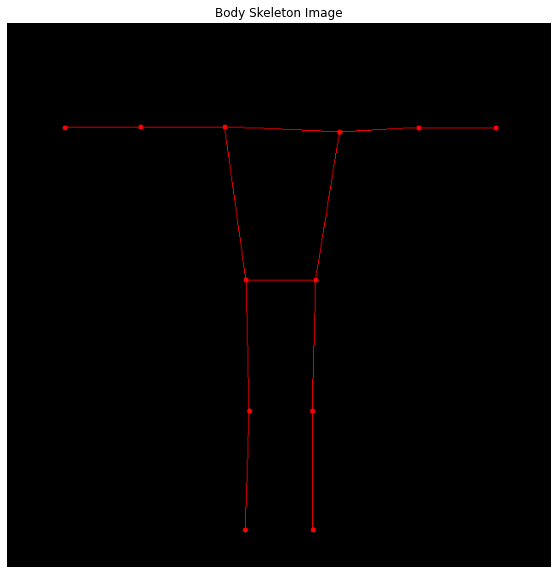

In [ ]:
image = cv2.imread('human t shape image.jpg')
black_image = np.zeros((3*image.shape[0]*image.shape[1])).reshape(image.shape[0], image.shape[1], 3)
output_image, body_skeleton_landmarks = detectPose(image, pose, display=False)

body_skeleton_img = getFullBodySkeleton(black_image, mp_pose, body_skeleton_landmarks)
plt.figure(figsize=[10,10])
#plt.subplot(111);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
plt.subplot(111);plt.imshow(body_skeleton_img[:,:,::-1]);plt.title("Body Skeleton Image");plt.axis('off');



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


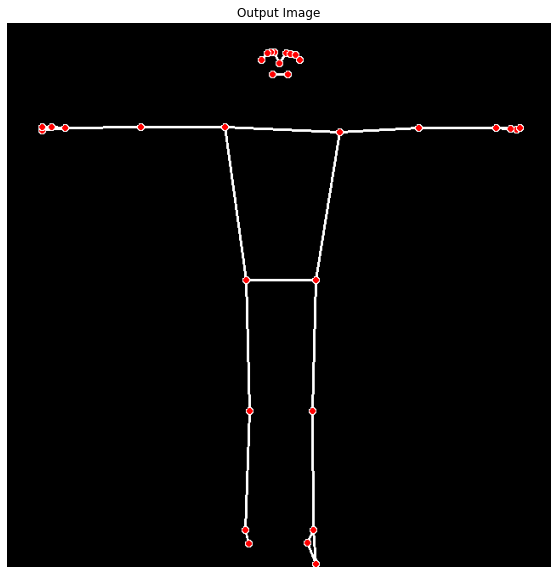

In [ ]:
# Don't run this code
# Read a sample image and perform pose classification on it.
image = cv2.imread('human t shape image.jpg')
output_image, landmarks = detectPose(image, black_image, pose, display=True)
#if landmarks:
#    classifyPose(landmarks, black_image, display=True)

In [ ]:
output_image.shape

(640, 640, 3)

In [ ]:
75*0.5

37.5

In [ ]:
int(np.round(7.7))

8

In [ ]:
def colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end):

    x_diff = keypoint2[0] - keypoint1[0]
    y_diff = keypoint2[1] - keypoint1[1]

    if abs(x_diff) > abs(y_diff):
        max_diff = abs(x_diff)
    else:
        max_diff = abs(y_diff)  

    x_change = x_diff/max_diff
    y_change = y_diff/max_diff   

    #print(f"keypoint 1 : {keypoint1}, keypoint2 : {keypoint2}")
    #print(f"x_chnage : {x_change} and y_change : {y_change}")
    #print(f"overlap start : {overlap_start} and overlap end : {overlap_end}")
    #print(f"Max diff : {max_diff}")

    iter_no = int(max_diff*abs(overlap_end - overlap_start)) 

    overlap_start *= 10
    overlap_end *= 10

    


    x1 = keypoint1[0] + overlap_start*(x_diff/10); y1 = keypoint1[1] + overlap_start*(y_diff/10)
    x2 = keypoint1[0] + overlap_end*(x_diff/10); y2 = keypoint1[1] + overlap_end*(y_diff/10)
    #x2 = keypoint1[0] + overlap_end*x_change + abs(x_change)/x_change; y2 = keypoint1[1] + overlap_end*y_change + abs(y_change)/y_change

    if overlap_start == 0:
        #body_skeleton_img[int(y1)][int(x1)] = [0, 255, 0]
        body_skeleton_img = cv2.circle(body_skeleton_img, (keypoint1[0], keypoint1[1]), 3, (0,255,0), -1)

    if overlap_end == 10:
        #body_skeleton_img[int(y1)][int(x1)] = [0, 255, 0]
        body_skeleton_img = cv2.circle(body_skeleton_img, (keypoint2[0], keypoint2[1]), 3, (0,255,0), -1)


    #print(f"Body skeleton shape : {body_skeleton_img.shape}")
    #print(f"(x1, y1) : ({x1}, {y1}) and (x2, y2) : ({x2}, {y2})")
    #print(f"iter no : {iter_no}")
    #while( int(x1) != x2 and int(y1) != y2 ):
    for  i in range(iter_no+1):
            
            #print(f"(x1, y1) : ({int(y1)}, {int(x1)})")
            body_skeleton_img[int(y1)][int(x1)] = [0, 255, 0]
            x1 += x_change             
            y1 += y_change


    return  body_skeleton_img          



In [ ]:
 
# import the opencv library
import cv2
from google.colab.patches import cv2_imshow
import glob
  
  
# define a video capture object
video_path = "/content/Frisking/frisking body.mp4"
labels_path = "/content/Frisking/Labels/*"

labels_path_list = glob.glob(labels_path)
labels_path_list = sorted(labels_path_list)

print("length of labels ", len(labels_path_list))


skeleton_left_shoulder_point = body_skeleton_landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
skeleton_right_shoulder_point = body_skeleton_landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
skeleton_left_elbow_point = body_skeleton_landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
skeleton_right_elbow_point = body_skeleton_landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value]
skeleton_left_wrist_point = body_skeleton_landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]
skeleton_right_wrist_point = body_skeleton_landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value]
skeleton_left_hip_point = body_skeleton_landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
skeleton_right_hip_point = body_skeleton_landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
skeleton_left_knee_point = body_skeleton_landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value]
skeleton_right_knee_point = body_skeleton_landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value]
skeleton_left_ankle_point = body_skeleton_landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value]
skeleton_right_ankle_point = body_skeleton_landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value]

#body_skeleton_img = body_skeleton_img.astype(int)

frameSize = (1280, 1280)

out = cv2.VideoWriter('frisking_body.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 30, frameSize)

vid = cv2.VideoCapture(video_path)

frame_no = 0
label_no = 0
count = 1

while(vid.isOpened()):
      
    ret, frame = vid.read()

    
    if count == 1:

        
        image = frame 
        
        frame, landmarks = detectPose(frame, pose, display=False)
        #print(f" frame number : {frame_no} and frame shape : {frame.shape} and landmarks : {landmarks}")
       
        try:
            detector_frame_path = labels_path_list[label_no] 
            detector_frame_no =  int(detector_frame_path[-12:-4])
        except:
            continue    
  

        if frame_no == detector_frame_no:
            
            label_file = open(detector_frame_path,"r")
            label = label_file.readline()[:-1].split(",")  # label is like ['Detector', '627', '545', '210', '175']
            detector_coordinates = []
            detector_coordinates.append(int(label[1]))
            detector_coordinates.append(int(label[2]))
            detector_coordinates.append(int(label[3]))
            detector_coordinates.append(int(label[4]))  

            

            #full body code starts

            left_shoulder_point = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
            right_shoulder_point = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
            left_elbow_point = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
            right_elbow_point = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value]
            left_wrist_point = landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]
            right_wrist_point = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value]
            left_hip_point = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
            right_hip_point = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
            left_knee_point = landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value]
            right_knee_point = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value]
            left_ankle_point = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value]
            right_ankle_point = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value]


            for i in range(12): 

                if i == 0:
                    keypoint1 = left_elbow_point
                    keypoint2 = left_wrist_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_left_elbow_point
                        keypoint2 = skeleton_left_wrist_point  
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass  

                elif i == 1:
                    keypoint1 = left_shoulder_point
                    keypoint2 = left_elbow_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_left_shoulder_point
                        keypoint2 = skeleton_left_elbow_point  
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass

                elif i == 2:
                    keypoint1 = left_shoulder_point
                    keypoint2 = right_shoulder_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_left_shoulder_point
                        keypoint2 = skeleton_right_shoulder_point
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass

                elif i == 3:
                    keypoint1 = right_shoulder_point
                    keypoint2 = right_elbow_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_right_shoulder_point
                        keypoint2 = skeleton_right_elbow_point  
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass

                elif i == 4:
                    keypoint1 = right_elbow_point
                    keypoint2 = right_wrist_point

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_right_elbow_point
                        keypoint2 = skeleton_right_wrist_point  
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass

                elif i == 5:
                    keypoint1 = right_shoulder_point
                    keypoint2 = right_hip_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_right_shoulder_point
                        keypoint2 = skeleton_right_hip_point
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass

                elif i == 6: 
                    keypoint1 = right_hip_point
                    keypoint2 = left_hip_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_right_hip_point
                        keypoint2 = skeleton_left_hip_point  
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass

                elif i == 7:
                    keypoint1 = left_shoulder_point
                    keypoint2 = left_hip_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_left_shoulder_point
                        keypoint2 = skeleton_left_hip_point  
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass

                elif i == 8:
                    keypoint1 = left_hip_point
                    keypoint2 = left_knee_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_left_hip_point
                        keypoint2 = skeleton_left_knee_point 
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass

                elif i == 9:
                    keypoint1 = left_knee_point 
                    keypoint2 = left_ankle_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_left_knee_point 
                        keypoint2 = skeleton_left_ankle_point 
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass

                elif i == 10:
                    keypoint1 = right_hip_point
                    keypoint2 = right_knee_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_right_hip_point
                        keypoint2 = skeleton_right_knee_point 
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass

                elif i == 11:  
                    keypoint1 = right_knee_point
                    keypoint2 = right_ankle_point 

                    try:
                        overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                        keypoint1 = skeleton_right_knee_point
                        keypoint2 = skeleton_right_ankle_point   
                        body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
                    except:
                        pass             
                  





            #full body code ends





            #black_image = np.zeros((image.shape[0], image.shape[1]))
        
            #skeleton_image = getSkeleton(black_image, landmarks, mp_pose)
            #detector_image  = getDetectorPosition(black_image, detector_frame_path)


            '''
            #1  
            left_shoulder_point = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
            left_elbow_point = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
            keypoint1 = left_shoulder_point
            keypoint2 = left_elbow_point 

            try:
                overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                
                skeleton_left_shoulder_point = body_skeleton_landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
                skeleton_left_elbow_point = body_skeleton_landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
                keypoint1 = skeleton_left_shoulder_point
                keypoint2 = skeleton_left_elbow_point  
                body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
            except:
                pass    


            #2
            left_elbow_point = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
            left_wrist_point = landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]
            keypoint1 = left_elbow_point
            keypoint2 = left_wrist_point 
            
            try:
                overlap_coordinates, overlap_start, overlap_end  = getOverlapCoordinates(keypoint1, keypoint2, detector_coordinates)
                
                skeleton_left_elbow_point = body_skeleton_landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
                skeleton_left_wrist_point = body_skeleton_landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]
                keypoint1 = skeleton_left_elbow_point 
                keypoint2 = skeleton_left_wrist_point  
                body_skeleton_img = colorDetectedBodyPart(body_skeleton_img, keypoint1, keypoint2, overlap_start, overlap_end)
            except:
                pass    

            '''

            body_skeleton_img_copy = body_skeleton_img.copy()
            body_skeleton_img_copy = body_skeleton_img_copy.astype(int)
            plt.figure(figsize=[15,10])
            img = cv2.resize(image, dsize=(body_skeleton_img.shape[0], body_skeleton_img.shape[1]))
            image_and_skeleton = np.concatenate((img, body_skeleton_img_copy), axis = 1)  
            print(f"frame shape : {frame.shape} and skeleton shape : {body_skeleton_img.shape} and image_and_skeleton shape : {image_and_skeleton.shape}")
            #plt.subplot(111);plt.imshow(image_and_skeleton[:,:,::-1]);plt.title("Original Image");plt.axis('off');          

            #print(f"1. overlap start : {overlap_start} and overlap end : {overlap_end}")
            #print(f"2. overlap start : {overlap_start} and overlap end : {overlap_end}")
            #plt.figure(figsize=[15,15])
            #plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
            #plt.subplot(122);plt.imshow(body_skeleton_img[:,:,::-1]);plt.title("Body Skeleton Image");plt.axis('off');    
            #cv2_imshow(image)
            #cv2_imshow(body_skeleton_img)
            image_and_skeleton_copy = image_and_skeleton[:,:,::-1].astype(np.uint8)
            image_and_skeleton_copy= np.pad(image_and_skeleton_copy, pad_width=[(int((1280-640)/2), int((1280-640)/2)),(0, 0),(0, 0)], mode='constant')
            out.write(image_and_skeleton_copy[:,:,::-1])

            print(f"label_no : {label_no} and frame_no : {frame_no} and detector_frame_no : {detector_frame_no}")
            label_no += 1 
             
            
    
        frame_no += 1



    
     

    if frame_no == 168:
        break

    #hand_coordinate_visited_unvisited = checkPixelPresent(hand_coordinate, labels_path)
    #image, accuracy = ColoringVisitedAndUnvisited(image, hand_coordinate_visited_unvisited)



    #print(f"Accuracy of Detection : {accuracy}")
    #print("Green color shows detector has visited that area and red color shows detector has not visited that area")
    
    #plt.figure(figsize=[10,10])
    #plt.imshow(image[:,:,::-1]);plt.title("Output Image");plt.axis('off');plt.show()
    #plt.imshow(black_image, cmap="gray");plt.title("Output Image");plt.axis('off');plt.show()

  
out.release()  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows() 

length of labels  169
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 0 and frame_no : 0 and detector_frame_no : 0
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 1 and frame_no : 1 and detector_frame_no : 1
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 2 and frame_no : 2 and detector_frame_no : 2
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 3 and frame_no : 3 and detector_frame_no : 3
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 4 and frame_no : 4 and detector_frame_no : 4
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 5 and frame_no : 5 and dete

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:294: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 20 and frame_no : 20 and detector_frame_no : 20
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 21 and frame_no : 21 and detector_frame_no : 21
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 22 and frame_no : 22 and detector_frame_no : 22
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 23 and frame_no : 23 and detector_frame_no : 23
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 24 and frame_no : 24 and detector_frame_no : 24
frame shape : (720, 1280, 3) and skeleton shape : (640, 640, 3) and image_and_skeleton shape : (640, 1280, 3)
label_no : 25 and frame_no : 25 and detector_

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

(720, 1280, 3)

In [ ]:
int((1280-640)/2)

320

# **Testing**

In [ ]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import glob

In [ ]:
!pip install mediapipe

     |████████████████████████████████| 30.4 MB 80 kB/s 


In [ ]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

In [ ]:

def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[5,5])
        #plt.subplot(111);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(111);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        #mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        return output_image, landmarks
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

KeyboardInterrupt: ignored

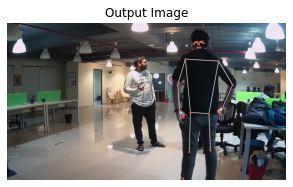

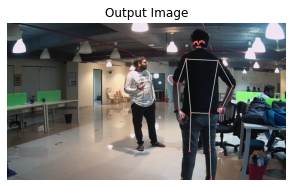

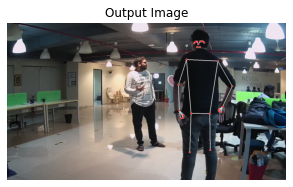

Error in callback <function flush_figures at 0x7f2f9cfab320> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
 # import the opencv library
import cv2
from google.colab.patches import cv2_imshow
import glob
  
  
# define a video capture object
video_path = "/content/WhatsApp Video 2021-09-30 at 8.02.04 PM.mp4"


vid = cv2.VideoCapture(video_path)

count = 1

while(True):
      
    ret, frame = vid.read()
    if count < 10:

        
        image = frame 
        frame, landmarks = detectPose(frame, pose, display=True)

    
    count += 1
    #hand_coordinate_visited_unvisited = checkPixelPresent(hand_coordinate, labels_path)
    #image, accuracy = ColoringVisitedAndUnvisited(image, hand_coordinate_visited_unvisited)



    #print(f"Accuracy of Detection : {accuracy}")
    #print("Green color shows detector has visited that area and red color shows detector has not visited that area")
    
    #plt.figure(figsize=[10,10])
    #plt.imshow(image[:,:,::-1]);plt.title("Output Image");plt.axis('off');plt.show()
    #plt.imshow(black_image, cmap="gray");plt.title("Output Image");plt.axis('off');plt.show()

  
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

# **Yolo Testing**

In [ ]:
import cv2
import mediapipe as mp
import time

mp_objectron = mp.solutions.objectron
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)


with mp_objectron.Objectron(static_image_mode = False,
                            max_num_objects = 2,
                            min_tracking_confidence = 0.8,
                            min_detection_confidence=0.7,
                            model_name = "Table Tennis Racket Detection") as objectron:

    while cap.isOpened():

        success, image = cap.read()

        start = time.time()


        # Convert the BGR image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image and find faces
        image.flags.writeable = False
        results = objectron.process(image)
        
        # Convert the image color back so it can be displayed
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


        if results.detected_objects:
            for detected_object in results.detected_objects:
                mp_drawing.draw_landmarks(image, detected_object.landmarks_2d, mp_objectron.BOX_CONNECTIONS)
                mp_drawing.draw_axis(image, detected_object.rotation, detected_object.translation)

            for id, detection in enumerate(results.detections):
                mp_draw.draw_detection(image, detection)
                print(id, detection)

                bBox = detection.location_data.relative_bounding_box

                h, w, c = image.shape

                boundBox = int(bBox.xmin * w), int(bBox.ymin * h), int(bBox.width * w), int(bBox.height * h)

                cv2.putText(image, f'{int(detection.score[0]*100)}%', (boundBox[0], boundBox[1] - 20), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2)





        end = time.time()
        totalTime = end - start

        fps = 1 / totalTime
        print("FPS: ", fps)

        cv2.putText(image, f'FPS: {int(fps)}', (20,70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 2)

        cv2.imshow('Face Detection', image)

        if cv2.waitKey(5) & 0xFF == 27:
            break
